### Compare standard Nevot-Croce models with VFP models

Starting with module imports

In [3]:
import sys
import os

sys.path.append(os.getcwd())

import numpy as np
import refnx
from refnx.dataset import ReflectDataset
from refnx.analysis import Transform, CurveFitter, Objective, GlobalObjective, Parameter
from refnx.reflect import SLD, ReflectModel, MixedReflectModel, Slab, Structure
import scipy
import periodictable
import matplotlib.pyplot as plt
%matplotlib inline

from VFP_v0_0_1 import VFP

We'll simulate a silicon substrate with a thin iron layer deposited on top + oxide layers we often expect. <br>
We'll simulate a measurement in D$_{2}$O using PNR (D$_{2}$O PNR). <br>
We'll also simulate a PNR measurement in air with orientation flipped (Air PNR). <br>
Finally, we'll also simulate an XRR measurement in air, again with the orientation flipped (Air XRR).<br>
Our sample will have the following structures across the three models:
| Layer | D$_{2}$O PNR | Air PNR | Air XRR |
| :---: | :---: | :---: | :---: |
| Fronting | Si | Air | Air |
| Layer 1 | SiO$_{2}$ | FeO$_{x}$ | FeO$_{x}$ |
| Layer 2 | Fe | Fe | Fe |
| Layer 3 | FeO$_{x}$ | SiO$_{2}$ | SiO$_{2}$ |
| Backing | D$_{2}$O | Si | Si |

In [4]:
# neutron scattering lengths for different materials simulated.

Si_sl = periodictable.Si.neutron.b_c_complex
SiO2_sl = periodictable.Si.neutron.b_c_complex + 2*periodictable.O.neutron.b_c_complex
Fe_sl = periodictable.Fe.neutron.b_c_complex
FeOx_sl = 2*periodictable.Fe.neutron.b_c_complex + 3*periodictable.O.neutron.b_c_complex
D2O_sl = 2*periodictable.D.neutron.b_c_complex + periodictable.O.neutron.b_c_complex

# x-ray form factor constants.
# if sf is function of multiple atoms then we need to seperately define f1 and f2.

Si_sf = periodictable.Si.xray.scattering_factors(wavelength=1.54)
SiO2_sf_f1 = periodictable.Si.xray.scattering_factors(wavelength=1.54)[0] + periodictable.Fe.xray.scattering_factors(wavelength=1.54)[0]
SiO2_sf_f2 = periodictable.Si.xray.scattering_factors(wavelength=1.54)[-1] + periodictable.Fe.xray.scattering_factors(wavelength=1.54)[-1]
Fe_sf = periodictable.Fe.xray.scattering_factors(wavelength=1.54)
FeOx_sf_f1 = 2*periodictable.Fe.xray.scattering_factors(wavelength=1.54)[0]+3*periodictable.O.xray.scattering_factors(wavelength=1.54)[0]
FeOx_sf_f2 = 2*periodictable.Fe.xray.scattering_factors(wavelength=1.54)[-1]+3*periodictable.O.xray.scattering_factors(wavelength=1.54)[-1]

# classical electron radius constant
thomp_e = 2.81794E-05 #angstrom

In [5]:
# now define some SLDs we will use...

# number density parameters for use
Si_dens = Parameter(0.0499, 'Si_dens', vary=False)
SiO2_dens = Parameter(0.0220, 'SiO2_dens', vary=False)
Fe_dens = Parameter(0.0849, 'Fe_dens', vary=False)
FeOx_dens = Parameter(0.0198, 'FeOx_dens', vary=False) # assuming its purely hematite.
D2O_dens = Parameter(0.0333, 'D2O_dens', vary=False)

# neutron SLDs defined so we can define layers later on.
# numbers don't matter here as they'll be re-defined below.
Si = SLD(2.07, name='Si')
SiO2 = SLD(3.47, name='SiO2')
Fe_Up = SLD(8.02, name='Fe_Up')
Fe_Down = SLD(8.02, name='Fe_Down')
FeOx_Up = SLD(7.0, name='FeOx_Up')
FeOx_Down = SLD(7.0, name='FeOx_Down')
D2O = SLD(6.2, name='D2O')

# xray SLDs.
# again, the precise numbers don't matter here as they'll be re-defined below (bar air).
Si_xray = SLD(complex(thomp_e*Si_sf[0]*Si_dens*1E6, thomp_e*Si_sf[-1]*Si_dens*1E6), name='Si_xray')
SiO2_xray = SLD(3.47, name='SiO2_xray')
Fe_xray = SLD(8.02, name='Fe_xray')
FeOx_xray = SLD(7.0, name='FeOx_xray')
Air = SLD(0.0, name='Air')

In [6]:
# these parameters will be used in the NR and XRR contrasts.

Si_SiO2_R = Parameter(5, 'Si_SiO2_rough', vary=False)

SiO2_thick = Parameter(50, 'SiO2_thick', vary=False)
SiO2_Fe_R = Parameter(3, 'SiO2_Fe_R', vary=False)

Fe_thick = Parameter(190, 'Fe_thick', vary=False)
Fe_magmom = Parameter(2.1, 'Fe_magmom', vary=False)
Fe_FeOx_R = Parameter(5, 'FeOx_Fe_rough', vary=False)

FeOx_thick = Parameter(30, 'FeOx_thick', vary=False)
FeOx_m = Parameter(0.5, 'FeOx_m', vary=False)
FeOx_R = Parameter(5, 'FeOx_rough', vary=False)

Lets first create some standard Nevot-Croce models

In [7]:
# Neutron layers

# in D2O
Si_lay = Si(0, 0)
Si_lay.sld.real.constraint = 1E-5*Si_sl.real*Si_dens*1E6
Si_lay.sld.imag.constraint = 1E-5*-Si_sl.imag*Si_dens*1E6

SiO2_lay = SiO2(SiO2_thick, Si_SiO2_R)
SiO2_lay.sld.real.constraint = 1E-5*SiO2_sl.real*SiO2_dens*1E6
SiO2_lay.sld.imag.constraint = 1E-5*-SiO2_sl.imag*SiO2_dens*1E6

Fe_up_lay = Fe_Up(Fe_thick, SiO2_Fe_R)
Fe_up_lay.sld.real.constraint = 1E-5*Fe_sl.real*Fe_dens*1E6 + Fe_dens*2.699*1E-5*Fe_magmom*1E6
Fe_up_lay.sld.imag.constraint = 1E-5*-Fe_sl.imag*Fe_dens*1E6

Fe_down_lay = Fe_Down(Fe_thick, SiO2_Fe_R)
Fe_down_lay.sld.real.constraint = 1E-5*Fe_sl.real*Fe_dens*1E6 - Fe_dens*2.699*1E-5*Fe_magmom*1E6
Fe_down_lay.sld.imag.constraint = 1E-5*-Fe_sl.imag*Fe_dens*1E6

FeOx_up_lay = FeOx_Up(FeOx_thick, Fe_FeOx_R)
FeOx_up_lay.sld.real.constraint = 1E-5*FeOx_sl.real*FeOx_dens*1E6 + FeOx_m
FeOx_up_lay.sld.imag.constraint = 1E-5*-FeOx_sl.imag*FeOx_dens*1E6

FeOx_down_lay = FeOx_Down(FeOx_thick, Fe_FeOx_R)
FeOx_down_lay.sld.real.constraint = 1E-5*FeOx_sl.real*FeOx_dens*1E6 - FeOx_m
FeOx_down_lay.sld.imag.constraint = 1E-5*-FeOx_sl.imag*FeOx_dens*1E6

D2O_lay = D2O(0, FeOx_R)
D2O_lay.sld.real.constraint = 1E-5*D2O_sl.real*D2O_dens*1E6
D2O_lay.sld.imag.constraint = 1E-5*-D2O_sl.imag*D2O_dens*1E6

# in air

Air_lay = Air(0, 0)

Air_FeOx_up_lay = FeOx_Up(FeOx_thick, FeOx_R)
Air_FeOx_up_lay.sld.real.constraint = 1E-5*FeOx_sl.real*FeOx_dens*1E6 + FeOx_m
Air_FeOx_up_lay.sld.imag.constraint = 1E-5*-FeOx_sl.imag*FeOx_dens*1E6

Air_FeOx_down_lay = FeOx_Down(FeOx_thick, FeOx_R)
Air_FeOx_down_lay.sld.real.constraint = 1E-5*FeOx_sl.real*FeOx_dens*1E6 - FeOx_m
Air_FeOx_down_lay.sld.imag.constraint = 1E-5*-FeOx_sl.imag*FeOx_dens*1E6

Air_Fe_up_lay = Fe_Up(Fe_thick, Fe_FeOx_R)
Air_Fe_up_lay.sld.real.constraint = 1E-5*Fe_sl.real*Fe_dens*1E6 + Fe_dens*2.699*1E-5*Fe_magmom*1E6
Air_Fe_up_lay.sld.imag.constraint = 1E-5*-Fe_sl.imag*Fe_dens*1E6

Air_Fe_down_lay = Fe_Down(Fe_thick, Fe_FeOx_R)
Air_Fe_down_lay.sld.real.constraint = 1E-5*Fe_sl.real*Fe_dens*1E6 - Fe_dens*2.699*1E-5*Fe_magmom*1E6
Air_Fe_down_lay.sld.imag.constraint = 1E-5*-Fe_sl.imag*Fe_dens*1E6

Air_SiO2_lay = SiO2(SiO2_thick, SiO2_Fe_R)
Air_SiO2_lay.sld.real.constraint = 1E-5*SiO2_sl.real*SiO2_dens*1E6
Air_SiO2_lay.sld.imag.constraint = 1E-5*-SiO2_sl.imag*SiO2_dens*1E6

Air_Si_lay = Si(0, Si_SiO2_R)
Air_Si_lay.sld.real.constraint = 1E-5*Si_sl.real*Si_dens*1E6
Air_Si_lay.sld.imag.constraint = 1E-5*-Si_sl.imag*Si_dens*1E6

#Xray layers

Si_xray_lay = Si_xray(0, Si_SiO2_R)

SiO2_xray_lay = SiO2_xray(SiO2_thick, SiO2_Fe_R)
SiO2_xray_lay.sld.real.constraint = thomp_e*SiO2_sf_f1*SiO2_dens*1E6
SiO2_xray_lay.sld.imag.constraint = thomp_e*SiO2_sf_f2*SiO2_dens*1E6

Fe_xray_lay = Fe_xray(Fe_thick, Fe_FeOx_R)
Fe_xray_lay.sld.real.constraint = thomp_e*Fe_sf[0]*Fe_dens*1E6
Fe_xray_lay.sld.imag.constraint = thomp_e*Fe_sf[1]*Fe_dens*1E6

FeOx_xray_lay = FeOx_xray(FeOx_thick, FeOx_R)
FeOx_xray_lay.sld.real.constraint = thomp_e*FeOx_sf_f1*FeOx_dens*1E6
FeOx_xray_lay.sld.imag.constraint = thomp_e*FeOx_sf_f2*FeOx_dens*1E6

Air_XRR_lay = Air(0, 0)

In [8]:
# create standard NC structures

# neutrons
D2O_PNR_up = Si_lay | SiO2_lay | Fe_up_lay | FeOx_up_lay | D2O_lay
D2O_PNR_down = Si_lay | SiO2_lay | Fe_down_lay | FeOx_down_lay | D2O_lay 

Air_PNR_up = Air_lay | Air_FeOx_up_lay | Air_Fe_up_lay | Air_SiO2_lay | Air_Si_lay
Air_PNR_down = Air_lay | Air_FeOx_down_lay | Air_Fe_down_lay | Air_SiO2_lay | Air_Si_lay

# xrays
Air_XRR = Air_XRR_lay | FeOx_xray_lay | Fe_xray_lay | SiO2_xray_lay | Si_xray_lay

In [9]:
# model

D2O_PNR_up_model = ReflectModel(D2O_PNR_up, scale=1, bkg=1e-6, dq=3*2.355) # 3 % dq/q std deviation to FWHM.
D2O_PNR_down_model = ReflectModel(D2O_PNR_down, scale=1, bkg=1e-6, dq=3*2.355)

Air_PNR_up_model = ReflectModel(Air_PNR_up, scale=1, bkg=1e-6, dq=3*2.355)
Air_PNR_down_model = ReflectModel(Air_PNR_down, scale=1, bkg=1e-6, dq=3*2.355)

Air_XRR_model = ReflectModel(Air_XRR, scale=1)

### Create a second model for each NC model above with the VFP

In [10]:
# first, init two lists of thicknesses and roughnesses parameters.

list_of_thickness = [0, SiO2_thick, Fe_thick, FeOx_thick] # first must be zero for Si thickness.
list_of_roughness = [Si_SiO2_R, SiO2_Fe_R, Fe_FeOx_R, FeOx_R]

In [11]:
# now init lists of SLDs.
# only the nuclear SLDs are required for the VFP, but if you
# have magnetic and imaginary SLDs calculated, these can also be
# passed to the VFP.

# neutron

# d2o
"""
The nSLDs are ordered as the following:
Si, SiO2, Fe, FeOx, D2O
"""

d2o_nuclear_SLDs = np.array([Si_lay.sld.real, 
                             SiO2_lay.sld.real, 
                             1E-5*Fe_sl.real*Fe_dens*1E6, # just pass the nuclear part.
                             1E-5*FeOx_sl.real*FeOx_dens*1E6, 
                             D2O_lay.sld.real])
                        
d2o_nuclear_iSLDs = np.array([Si_lay.sld.imag, 
                              SiO2_lay.sld.imag, 
                              1E-5*-Fe_sl.imag*Fe_dens*1E6, 
                              1E-5*-FeOx_sl.imag*FeOx_dens*1E6,
                              D2O_lay.sld.imag])

d2o_magnetic_SLDs = np.array([0, # if no magnetic SLD, just pass 0.
                              0, 
                              Fe_dens*2.699*1E-5*Fe_magmom*1E6, 
                              FeOx_m, 
                              0])

# air - we keep the orientation the same as the d2o.

air_nuclear_SLDs = np.array([Air_Si_lay.sld.real, 
                             Air_SiO2_lay.sld.real, 
                             1E-5*Fe_sl.real*Fe_dens*1E6,
                             1E-5*FeOx_sl.real*FeOx_dens*1E6, 
                             Air_lay.sld.real])
                        
air_nuclear_iSLDs = np.array([Air_Si_lay.sld.imag, 
                              Air_SiO2_lay.sld.imag, 
                              1E-5*-Fe_sl.imag*Fe_dens*1E6, 
                              1E-5*-FeOx_sl.imag*FeOx_dens*1E6,
                              Air_lay.sld.imag]) # assume air doesnt have imaginary sld.

air_magnetic_SLDs = np.array([0, 
                              0, 
                              Fe_dens*2.699*1E-5*Fe_magmom*1E6, 
                              FeOx_m, 
                              0])

In [12]:
# xray - again keep the orientation the same as the d2o.

"""
The nuclear and imaginary SLDs are ordered as the following:
Si, SiO2, Fe, FeOx, Air
"""

xray_SLDs = np.array([Si_xray_lay.sld.real,
                      SiO2_xray_lay.sld.real,
                      Fe_xray_lay.sld.real,
                      FeOx_xray_lay.sld.real,
                      Air_XRR_lay.sld.real])
                        
xray_iSLDs = np.array([Si_xray_lay.sld.imag,
                      SiO2_xray_lay.sld.imag,
                      Fe_xray_lay.sld.imag,
                      FeOx_xray_lay.sld.imag,
                      Air_XRR_lay.sld.imag])

# we don't need to define a magnetic SLD array.

In [13]:
# now define the VFP components
# we'll see a warning that suggests we need to pass any parameters that are only
# defined in the SLD lists in a function of other parameters to the auxiliary parameter list
# as we're not going to fit the model to any data here, we can simply ignore.

d2o_up_vfp = VFP(nucSLDs=d2o_nuclear_SLDs, 
                 thicknesses=list_of_thickness,
                 roughnesses=list_of_roughness,
                 nuciSLDs=d2o_nuclear_iSLDs,
                 magSLDs=d2o_magnetic_SLDs,
                 spin_state='up')

d2o_down_vfp = VFP(nucSLDs=d2o_nuclear_SLDs, 
                   thicknesses=list_of_thickness,
                   roughnesses=list_of_roughness,
                   nuciSLDs=d2o_nuclear_iSLDs,
                   magSLDs=d2o_magnetic_SLDs,
                   spin_state='down')

air_up_vfp = VFP(nucSLDs=air_nuclear_SLDs, 
                 thicknesses=list_of_thickness,
                 roughnesses=list_of_roughness,
                 nuciSLDs=air_nuclear_iSLDs,
                 magSLDs=air_magnetic_SLDs,
                 spin_state='up',
                 orientation='back') # this option is used to flip the order of the sample structure.

air_down_vfp = VFP(nucSLDs=air_nuclear_SLDs, 
                   thicknesses=list_of_thickness,
                   roughnesses=list_of_roughness,
                   nuciSLDs=air_nuclear_iSLDs,
                   magSLDs=air_magnetic_SLDs,
                   spin_state='down',
                   orientation='back')

XRR_vfp = VFP(nucSLDs=xray_SLDs, 
              thicknesses=list_of_thickness,
              roughnesses=list_of_roughness,
              nuciSLDs=xray_iSLDs,
              orientation='back')

C:\Users\soo29949\OneDrive - Science and Technology Facilities Council\Git_repos\VFP\Examples\VFP_v0_0_1.py:181: UserWarning: Pass nucSLD parameters that are only part of a parameter operation (i.e f(p1, p2) = p1 + p2) to the auxiliary parameters argument of the objective.
  warnings.warn(
C:\Users\soo29949\OneDrive - Science and Technology Facilities Council\Git_repos\VFP\Examples\VFP_v0_0_1.py:221: UserWarning: Pass magSLD parameters that are only part of a parameter operation (i.e f(p1, p2) = p1 + p2) to the auxiliary parameters argument of the objective.
  warnings.warn(
C:\Users\soo29949\OneDrive - Science and Technology Facilities Council\Git_repos\VFP\Examples\VFP_v0_0_1.py:236: UserWarning: Pass nuciSLD parameters that are only part of a parameter operation (i.e f(p1, p2) = p1 + p2) to the auxiliary parameters argument of the objective.
  warnings.warn(


In [14]:
# structure

# wrap the VFPs by the SLD of the fronting and backing (not the actual layers themselves)

# neutrons
D2O_PNR_up_VFP = Si_lay.sld | d2o_up_vfp | D2O_lay.sld
D2O_PNR_down_VFP = Si_lay.sld | d2o_down_vfp | D2O_lay.sld

Air_PNR_up_VFP = Air_lay.sld | air_up_vfp | Si_lay.sld
Air_PNR_down_VFP = Air_lay.sld | air_down_vfp | Si_lay.sld

# xrays
Air_XRR_VFP = Air_XRR_lay.sld | XRR_vfp | Si_xray_lay.sld

In [15]:
D2O_PNR_up_VFP_model = ReflectModel(D2O_PNR_up_VFP, scale=1, bkg=1e-6, dq=3*2.355)
D2O_PNR_down_VFP_model = ReflectModel(D2O_PNR_down_VFP, scale=1, bkg=1e-6, dq=3*2.355)

Air_PNR_up_VFP_model = ReflectModel(Air_PNR_up_VFP, scale=1, bkg=1e-6, dq=3*2.355)
Air_PNR_down_VFP_model = ReflectModel(Air_PNR_down_VFP, scale=1, bkg=1e-6, dq=3*2.355)

Air_XRR_VFP_model = ReflectModel(Air_XRR_VFP, scale=1)

### Now lets compare the structure and modelled reflectivity of each simulated measurement

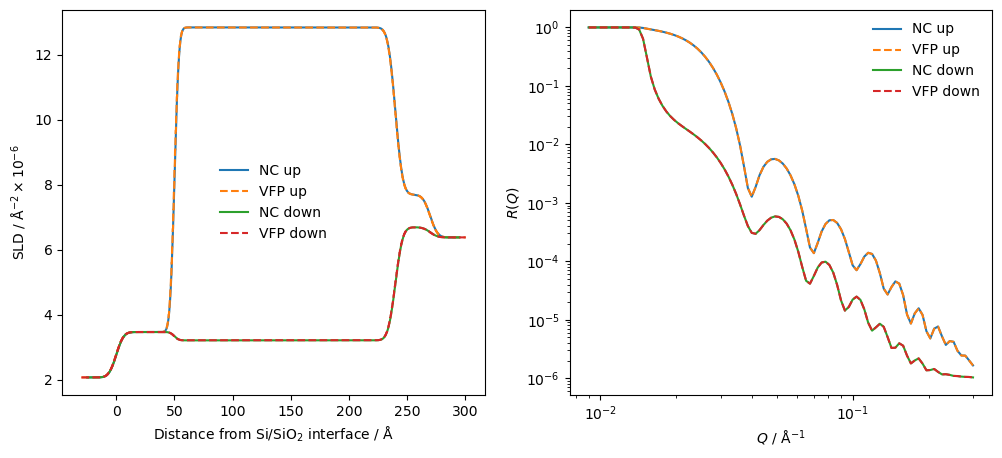

In [19]:
# D2O

microslice = 0.5

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(*D2O_PNR_up_model.structure.sld_profile(), label=r'NC up')
ax[0].plot(D2O_PNR_up_VFP_model.structure.sld_profile(max_delta_z=microslice/2)[0]+D2O_PNR_up_VFP_model.structure.components[1].SLD_offset(), 
           D2O_PNR_up_VFP_model.structure.sld_profile(max_delta_z=microslice/2)[1],
           linestyle='--', label=r'VFP up')

ax[0].plot(*D2O_PNR_down_model.structure.sld_profile(), label=r'NC down')
ax[0].plot(D2O_PNR_down_VFP_model.structure.sld_profile(max_delta_z=microslice/2)[0]+D2O_PNR_down_VFP_model.structure.components[1].SLD_offset(), 
           D2O_PNR_down_VFP_model.structure.sld_profile(max_delta_z=microslice/2)[1],
           linestyle='--', label=r'VFP down')

ax[0].set_xlabel(r'Distance from Si/SiO$_{2}$ interface / $\mathrm{\AA}$')
ax[0].set_ylabel(r'$\mathrm{SLD}$ / $\mathrm{\AA{}}^{-2} \times 10^{-6}$')
ax[0].legend(frameon=False)

Q = np.geomspace(9E-3, 3E-1, 100)
ax[1].plot(Q, D2O_PNR_up_model.model(x=Q), label=r'NC up')
ax[1].plot(Q, D2O_PNR_up_VFP_model.model(x=Q), linestyle='--', label=r'VFP up')
ax[1].plot(Q, D2O_PNR_down_model.model(x=Q), label=r'NC down')
ax[1].plot(Q, D2O_PNR_down_VFP_model.model(x=Q), linestyle='--', label=r'VFP down')
ax[1].legend(frameon=False)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel(r'$R\left(Q\right)$')
ax[1].set_xlabel(r'$Q$ / $\mathrm{\AA{}}^{-1}$')
plt.show()

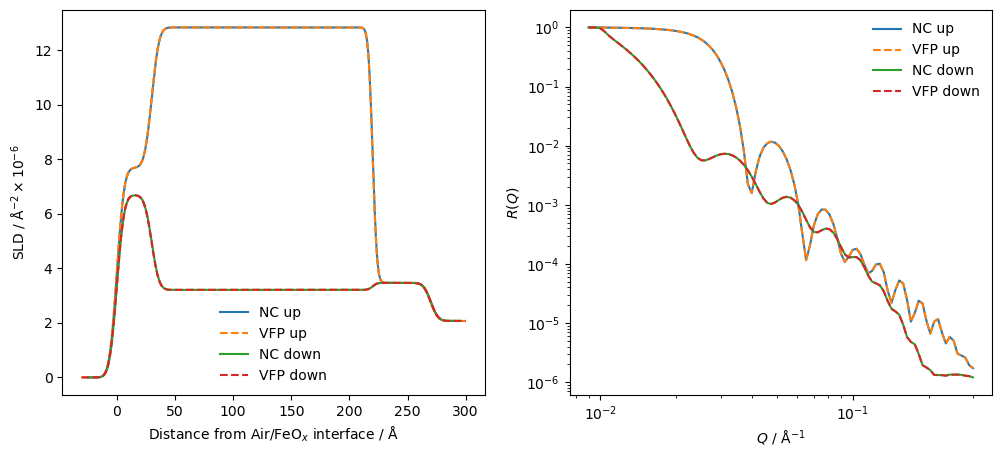

In [20]:
# air

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(*Air_PNR_up_model.structure.sld_profile(), label=r'NC up')
ax[0].plot(Air_PNR_up_VFP_model.structure.sld_profile(max_delta_z=microslice/2)[0]+Air_PNR_up_VFP_model.structure.components[1].SLD_offset(), 
           Air_PNR_up_VFP_model.structure.sld_profile(max_delta_z=microslice/2)[1],
           linestyle='--', label=r'VFP up')

ax[0].plot(*Air_PNR_down_model.structure.sld_profile(), label=r'NC down')
ax[0].plot(Air_PNR_down_VFP_model.structure.sld_profile(max_delta_z=microslice/2)[0]+Air_PNR_down_VFP_model.structure.components[1].SLD_offset(), 
           Air_PNR_down_VFP_model.structure.sld_profile(max_delta_z=microslice/2)[1],
           linestyle='--', label=r'VFP down')

ax[0].set_xlabel(r'Distance from Air/FeO$_{x}$ interface / $\mathrm{\AA}$')
ax[0].set_ylabel(r'$\mathrm{SLD}$ / $\mathrm{\AA{}}^{-2} \times 10^{-6}$')
ax[0].legend(frameon=False)

Q = np.geomspace(9E-3, 3E-1, 100)
ax[1].plot(Q, Air_PNR_up_model.model(x=Q), label=r'NC up')
ax[1].plot(Q, Air_PNR_up_VFP_model.model(x=Q), linestyle='--', label=r'VFP up')
ax[1].plot(Q, Air_PNR_down_model.model(x=Q), label=r'NC down')
ax[1].plot(Q, Air_PNR_down_VFP_model.model(x=Q), linestyle='--', label=r'VFP down')
ax[1].legend(frameon=False)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel(r'$R\left(Q\right)$')
ax[1].set_xlabel(r'$Q$ / $\mathrm{\AA{}}^{-1}$')
plt.show()

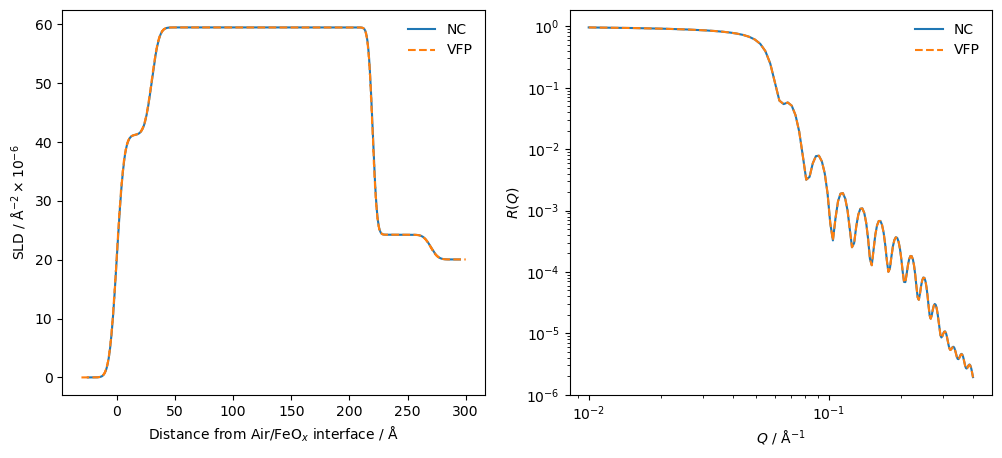

In [21]:
# finally, XRR in air.

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(*Air_XRR_model.structure.sld_profile(), label=r'NC')
ax[0].plot(Air_XRR_VFP_model.structure.sld_profile(max_delta_z=microslice/2)[0]+Air_XRR_VFP_model.structure.components[1].SLD_offset(), 
           Air_XRR_VFP_model.structure.sld_profile(max_delta_z=microslice/2)[1],
           linestyle='--', label=r'VFP')

ax[0].set_xlabel(r'Distance from Air/FeO$_{x}$ interface / $\mathrm{\AA}$')
ax[0].set_ylabel(r'$\mathrm{SLD}$ / $\mathrm{\AA{}}^{-2} \times 10^{-6}$')
ax[0].legend(frameon=False)

Q = np.linspace(1E-2, 4E-1, 150)
ax[1].plot(Q, Air_XRR_model.model(x=Q), label=r'NC')
ax[1].plot(Q, Air_XRR_VFP_model.model(x=Q), linestyle='--', label=r'VFP')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].legend(frameon=False)
ax[1].set_ylabel(r'$R\left(Q\right)$')
ax[1].set_xlabel(r'$Q$ / $\mathrm{\AA{}}^{-1}$')
plt.show()

### Conclusion
We can see the above three plots show the same SLD structures and reflectivities, and hence we have good agreement between the VFP and the Nevot-Croce model when roughnesses are small compared to thicknesses.